## I. Read Files

In [1]:
import pandas as pd
import os, re
import datetime
import numpy as np

In [2]:
# Location that contains the data
data_folder   = "./data"
# Location where results will be saved to
output_folder = "./reports"

In [3]:
# --- Read Files in Data Folder --- 
files = os.listdir(os.path.join(data_folder)) # List files in folder
files = [file for file in files if "zip" not in file] # Ignore .zip files if existent in folder
# Read file data
all_tables = dict()
for file in files:
    name       = re.sub(".csv", "", file)
    all_tables[name] = pd.read_csv(os.path.join(data_folder, file))

## II. Pre-process Files

In [4]:
# This section will preprocess the dataset and produce our classification/analysis 
# table, which will have the name of main_df

# Call dataframe from dictionary
tackles     = all_tables["tackles"]

In [5]:
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# A. Build dataset starting from outcome
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
## Create outcome dataframe
### Note: Tackles is the most important table in the dataframe because 
### it contains our outcome variable. We will build our main dataset from here. 
main_df = tackles.loc[(tackles.tackle == 1) | (tackles.pff_missedTackle == 1)] # We are only interested either in tackle attempts (either missed or unsuccessful)
main_df = main_df.loc[main_df.tackle != main_df.pff_missedTackle]  # Keep only misses OR successful tackles (not both) in order to avoid feeding ambiguity into our classifier
main_df = main_df.loc[main_df.assist != 1]                         # We want our outcome to be as unambiguous and separable as possible, hence missed tackles which were ALSO assists (of which there are 42 cases) are to be removed
main_df["tackle_outcome"] = main_df.tackle                         # Out outcome variable will have a value of 1 when tackle successful, and 0 when it was missed [we are interested in misses, but the opposite naming convention would be counter-intuitive]
## Remove variables that won't be used 
main_df.drop(["tackle", "assist", "forcedFumble", "pff_missedTackle"], axis = 1, inplace = True)

#>>>>>>>>>>>>>>>>>>>>>>
# B. Add player data
#>>>>>>>>>>>>>>>>>>>>>>
# Add player data through a merge
main_df = pd.merge(main_df, all_tables["players"], on = "nflId", how = "left")
# We next proceed to process a few non-numeric variables into a more appropriate form
## -- Convert Height to a continuous, numeric variable --
## Define conversion function
def getImperialFraction(x):
    imperial_list = x.split("-")
    imperial_frac = int(imperial_list[0]) + int(imperial_list[1])/12
    return imperial_frac 
## Apply
main_df["height"]    = main_df.height.apply(getImperialFraction)
## -- Convert Birthdate numeric age variable ---
## Age is recorded in more than one format, hence the rowwise conversion function 
### Define conversion function
def getAgeFromBirthday(x):
    if pd.isnull(x):
        age = np.nan
    else:
        age = (datetime.datetime.now() - pd.to_datetime(x)).days / 365
    return age
### Apply
main_df["age"] = main_df.birthDate.apply(getAgeFromBirthday)
### Remove original variable, which is no longer useful
main_df.drop("birthDate", axis = 1, inplace = True)

#>>>>>>>>>>>>>>>>>>>>>>
# C. Add play data
#>>>>>>>>>>>>>>>>>>>>>>
# Add play data through a merge
main_df = pd.merge(main_df, all_tables["plays"], on = ["gameId", "playId"], how = "left")
# --- Convert gameClock from string to continuous numeric variable (holding minutes) ---
main_df[["minutes", "seconds"]] = main_df.gameClock.str.split(":", expand = True)
main_df.minutes = main_df.minutes.astype(int)
main_df.seconds = main_df.seconds.astype(int)
main_df["gameClock_minutes"] = main_df.minutes + main_df.seconds/60
## Drop unnecessary variables
main_df.drop(["minutes", "seconds", "gameClock"], axis = 1, inplace = True)
# --- Auxiliary yardline variables ---
# Determine whether the side of the field they're in is on the defense or offense side
main_df["yardline_half"] = main_df.apply(lambda row: "first_half" if pd.isnull(row.yardlineSide) else \
                                         "first_half" if row.possessionTeam == row.yardlineSide else  \
                                         "second_half", axis = 1)
# Get the absolute yardline number, viewed from the offensive team's standpoint    
main_df["yardlineNumber_absolute"] = main_df.apply(lambda row: row.yardlineNumber if row.yardline_half == "first_half" else \
                                                   row.yardlineNumber + 50, axis = 1)

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# D. Add play tracking data
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Note: We will mainly extract the following two sets of information
# from tracking data: (1) the speed, strength, position, and 
# angle from the player that made the tackle [which unfortunately is not 
# available for every play], and (2) whether the play in question had an 
# each of the possible events in the tracking df [that is a pass, a play, a fumble, etc]

#-----------------------
# i. Data preparation
#-----------------------
# The tracking dataset is massive, yet we ultimately only need the observations that 
# pertain to our available game-player-play combinations, hence we will filter them out
# first.

# -- Create reference with the available ids --
id_vars              = ["gameId", "playId", "nflId"] # For easier multiple reference later on
unique_ids_df        = main_df[id_vars].drop_duplicates()
# -- Filter each available dataset to the id combinations at hand --
tracking_table_names = [key for key in all_tables.keys() if "tracking_" in key ]
holder_filtered_dict = dict()
for tracking_table in tracking_table_names:
    ## We are to filter the dataset using a merge because what is important for us is the 
    ## Combination of the 3-ids (game, play, player) at the same time and within the same observation. 
    ## By doing a 'left' join were're essentially subsetting the tacking dataset at hand to only those
    ## observations with id combinations in our unique_ids_df table
    holder_filtered_dict[f"{tracking_table}_filtered"] = pd.merge(unique_ids_df, all_tables[tracking_table], on = id_vars, how = "left")
## Join the matches from each file into a single dataframe
tracking_data_filtered = pd.concat(holder_filtered_dict, ignore_index = True)

#-----------------------
# ii. Tackle metadata
#-----------------------
# We now proceed to retrieve the attributes that pertain to the moment of tackle itself
# -- Filter tracking data for tackle events --
tackle_events = tracking_data_filtered.loc[tracking_data_filtered.event == "tackle"]
## Select the relevant columns and add "tackle_" as a prefix to their name
positional_cols = ['x','y','s','a','dis','o','dir']
tackle_events.rename({key:f"tackle_{key}" for key in positional_cols}, axis = 1, inplace = True)
### Manually make names even more understandable
tackle_events.rename({"tackle_x": "tackle_x_position", "tackle_y": "tackle_y_position",
                        "tackle_s": "tackle_speed", "tackle_a": "tackle_acceleration",
                        "tackle_dis": "tackle_distance", "tackle_o": "tackle_orientation",
                        "tackle_dir": "tackle_angle"}, axis = 1, inplace = True)
# Join with the main dataset through a merge
main_df = pd.merge(main_df, tackle_events.drop("displayName", axis = 1), on = id_vars, how = "left")

#-----------------------
# ii. Event data
#-----------------------
# We now proceed to create a columns that work as binary indicators regarding whether 
# each of the possible tracked events (forward pass, shovel pass, etc.) ocurred in this play
play_events_list = tracking_data_filtered.event.drop_duplicates() # List possible play events
for play_event in play_events_list:
    if pd.notnull(play_event):     # Play event can be null, so we don't want it to interfere with our table
        tracking_data_filtered[f"event_{play_event}"] = (tracking_data_filtered.event == play_event).astype(int)
## Record the new column names pertaining to events
event_cols     = [col for col in tracking_data_filtered.columns if "event_" in col]
# At this point we only have the event = 1 for that instance of the play, while the rest of it has 
# a value of 0. We hence need to summarize the dataset so we get the "max" event value [either 0 or 1] 
# for the play as a whole; hence effectively giving us flag for which events ocurred during the play. 
play_events_df = tracking_data_filtered.groupby(id_vars)[event_cols].max()

# Add event data through a merge
main_df = pd.merge(main_df, play_events_df, on = id_vars, how = "left")

C:\Users\monac\AppData\Local\Temp\ipykernel_824\704069909.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tackle_events.rename({key:f"tackle_{key}" for key in positional_cols}, axis = 1, inplace = True)
C:\Users\monac\AppData\Local\Temp\ipykernel_824\704069909.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tackle_events.rename({"tackle_x": "tackle_x_position", "tackle_y": "tackle_y_position",


## III. (a) Basic Variable Stats

In [6]:
# We now proceed to screen through the variables through the means of a statistical
# test that will evaluate whether there is or not a relationship between each attribute
# and whether the tackle's outcome was a success or a miss. Given that this output 
# variable is binary, it is hence not advisable to use a traditional one-way anova 
# (which evaluates numeric, continuous outcomes). In order to test each attribute as 
# a whole, this script has implemented a custom function that replicates the native 
# R function anova(test = "Chisq"), which has the ability in R to analogically perform
# a "one-way anova" on a binary outcome through the means of the Chi-squared likelihood
# ratio test. The custom function summarizeDF is also supposed to be an aid in screening 
# the dataset, by providing a practical summary of what is contained in each attribute column.
# This summary is not essential, however, so it can be removed from the script if the intend is 
# merely to simplify it. 

from scipy.stats import chi2
import statsmodels.api as sm
import statsmodels.formula.api as smf
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Define custom auxiliary functions
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
def colMissingVals(df):
    """
    Calculate the percentage of missing values in each column of a DataFrame.
    """
    missing_counts = df.isnull().sum()
    total_counts = len(df)
    missing_percentage = (missing_counts / total_counts) * 100
    missing_df = pd.DataFrame({'Col': missing_counts.index, 'Na_Pcnt': missing_percentage.values})
    return missing_df

# def orderCols(df, column_order):
#     """
#     Reorder columns in a DataFrame based on a specified order.
#     """
#     return df[column_order]

def summarizeDf(df, empty_strings_to_nans = True):
    """
    Provides a summary of the columns in the dataset: 
    First non-empty value, missing values, n unique values
    """
    if empty_strings_to_nans == True: 
        df[df == ""] = np.nan
    df_sample    = df.fillna(method = "bfill").iloc[0].reset_index().rename({"index": "Attribute", 0: "Sample Value"}, axis = 1)
    df_nas       = colMissingVals(df).rename({"Col": "Attribute", "Na_Pcnt": "% Missing"}, axis = 1)
    non_missing_count = df.notnull().sum().reset_index().rename({"index": "Attribute", 0: "# Non Missing"}, axis = 1)
    ## Datatypes
    datatypes = df.dtypes.reset_index().rename({"index": "Attribute", 0: "python_type"}, axis = 1)
    ## Unique value
    unique_vals = df.nunique(axis=0).reset_index().rename({"index": "Attribute", 0: "Unique Values"}, axis=1)
    # Merge all indicators
    summary_df = pd.merge(df_sample, df_nas, on = "Attribute", how = "outer")
    summary_df = pd.merge(summary_df, non_missing_count, on = "Attribute", how = "outer")
    summary_df = pd.merge(summary_df, datatypes, on = "Attribute", how = "outer")
    summary_df = pd.merge(summary_df, unique_vals, on = "Attribute", how = "outer")
    summary_df = summary_df.assign(N_Observations = len(df))
    
    # summary_df = orderCols(summary_df, ["Attribute", "python_type"])
    return summary_df

# Auxiliary fucntion
def chi2Anova(df, predictor, outcome_col, normalize_output_statistic = True):
    """
    Performs a chi-squared likelihood-ratio test that acts as a one-way Anova 
    (at least it is called such in R) to test the null hypothesis: 
    "the selected {predictor} variable does not have a statistically significant relationship 
    with the binary variable {outcome_col}"
    """
    # Subset variable
    df_sub = df[[predictor, outcome_col]]
    df_sub = df_sub.loc[df_sub.notnull().all(axis = 1)] # Remove missing values for the relevant columns
    # --- Create logistic model ---
    # Determine if variables is numeric
    if df_sub[predictor].dtype != "O":
        ## Procedure for numeric predictor
        formula = outcome_col + " ~ " + predictor
        model   = smf.glm(formula=formula, data=df_sub, family=sm.families.Binomial()).fit()
    else:
        ## Procedure for categorical (character) predictor
        ### Convert characters to numeric vars
        df_lm = pd.get_dummies(df_sub[[predictor, outcome_col]], columns=[predictor], drop_first=True, dtype = int)
        ### Format column names appropriately
        df_lm.columns   = [re.sub(" ", "_", predictor) for predictor in df_lm.columns]
        df_lm.columns   = [re.sub("[^a-zA-Z0-9_]", "", predictor) for predictor in df_lm.columns]
        predictors_cols = df_lm.columns[df_lm.columns != outcome_col]
        ### Create prediction formula by joining predictors
        predictors      = ' + '.join(predictors_cols)
        formula         = outcome_col + " ~ " + predictors
        model           = smf.glm(formula=formula, data=df_lm, family=sm.families.Binomial()).fit()
        # print(model.summary())
    # --- Create dummy (control) model ---
    control_model = smf.glm(formula = "tackle_outcome ~ ones", data = df_sub.assign(ones = 1), 
                            family = sm.families.Binomial()).fit()
    # --- Perform Likelihood-ratio chi-squared test ---
    lr      = -2*(control_model.llf - model.llf)
    test_df = model.df_model - control_model.df_model #df (degrees of freedom) is the difference in number of parameters between two models
    pval    = chi2.sf(lr, df = test_df) 
    if normalize_output_statistic:
        return {"test_statistic": lr/(test_df), "p_value": pval} # Divide statistic by the degrees of freedom to make it comparable across tests
    else:
        return {"test_statistic": lr, "p_value": pval}

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Perform statistical analysis
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Get data summary
summary_df                   = summarizeDf(main_df)
summary_df["Test statistic"] = np.nan # Test statistic column to populate
summary_df["Anova P-Val"]    = np.nan # P-value column to populate
## Select variables to exclude from the analysis
outcome_var      = "tackle_outcome"
vars_to_exclude  = id_vars + ["ballCarrierId", "playDescription", "event", "time"]

# Perform logistic one-way anova in order to get a p-value on its significance
for i, col in enumerate(main_df.columns):
    if (col not in outcome_var) & (col not in vars_to_exclude):
        print(f"Chi-Squared Anova test on column {i}/{len(main_df.columns)}: {col}")
        chi2_test = chi2Anova(main_df, predictor = col, outcome_col = outcome_var)
        summary_df.loc[summary_df.Attribute == col, "Test statistic"] = chi2_test["test_statistic"]
        summary_df.loc[summary_df.Attribute == col, "Anova P-Val"]    = chi2_test["p_value"]
        
# Export files
main_df.to_parquet(os.path.join(output_folder, "main_df.parquet")) 
summary_df.to_excel(os.path.join(output_folder, "Attribute Statistical Summary.xlsx"), index = False)

Chi-Squared Anova test on column 4/82: height
Chi-Squared Anova test on column 5/82: weight
Chi-Squared Anova test on column 6/82: collegeName
Chi-Squared Anova test on column 7/82: position
Chi-Squared Anova test on column 8/82: displayName
Chi-Squared Anova test on column 9/82: age
Chi-Squared Anova test on column 11/82: ballCarrierDisplayName
Chi-Squared Anova test on column 13/82: quarter
Chi-Squared Anova test on column 14/82: down
Chi-Squared Anova test on column 15/82: yardsToGo
Chi-Squared Anova test on column 16/82: possessionTeam
Chi-Squared Anova test on column 17/82: defensiveTeam
Chi-Squared Anova test on column 18/82: yardlineSide
Chi-Squared Anova test on column 19/82: yardlineNumber
Chi-Squared Anova test on column 20/82: preSnapHomeScore
Chi-Squared Anova test on column 21/82: preSnapVisitorScore
Chi-Squared Anova test on column 22/82: passResult
Chi-Squared Anova test on column 23/82: passLength
Chi-Squared Anova test on column 24/82: penaltyYards
Chi-Squared Anova te

## III. (b) Basic Variable Plots

Plotting attribute 0/74: frameId
Plotting attribute 1/74: tackle_acceleration
Plotting attribute 2/74: tackle_distance
Plotting attribute 3/74: tackle_speed
Plotting attribute 4/74: tackle_angle
Plotting attribute 5/74: jerseyNumber
Plotting attribute 6/74: tackle_y_position
Plotting attribute 7/74: tackle_x_position
Plotting attribute 8/74: tackle_orientation
Plotting attribute 9/74: playDirection
Plotting attribute 10/74: club
Plotting attribute 11/74: prePenaltyPlayResult
Plotting attribute 12/74: expectedPointsAdded
Plotting attribute 13/74: playResult
Plotting attribute 14/74: passLength
Plotting attribute 15/74: event_touchdown
Plotting attribute 16/74: ballCarrierDisplayName
Plotting attribute 17/74: displayName
Plotting attribute 18/74: penaltyYards
Plotting attribute 19/74: event_handoff
Plotting attribute 20/74: event_pass_outcome_caught
Plotting attribute 21/74: event_ball_snap
Plotting attribute 22/74: position
Plotting attribute 23/74: event_first_contact
Plotting attribut

C:\Users\monac\AppData\Local\Temp\ipykernel_824\2999384428.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["tackle_angle_bin"] = round(filtered_df.tackle_angle/10)*10 + 5


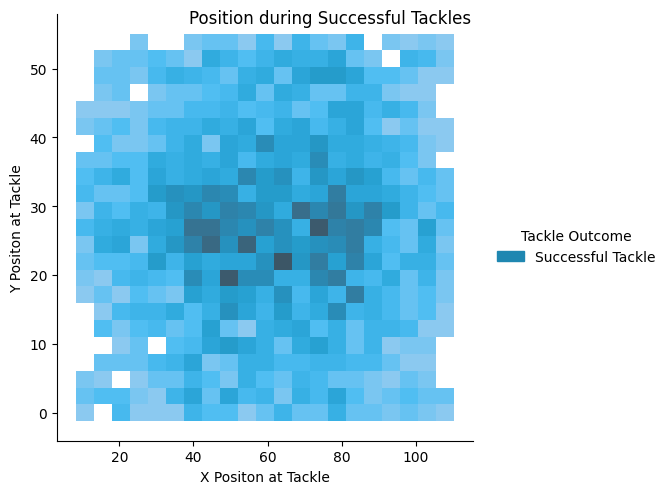

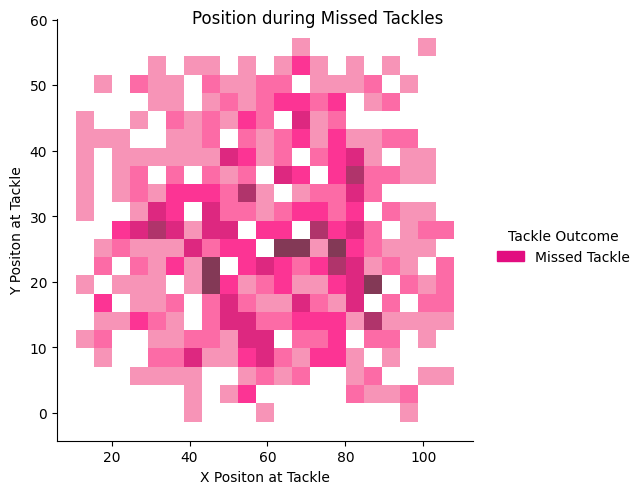

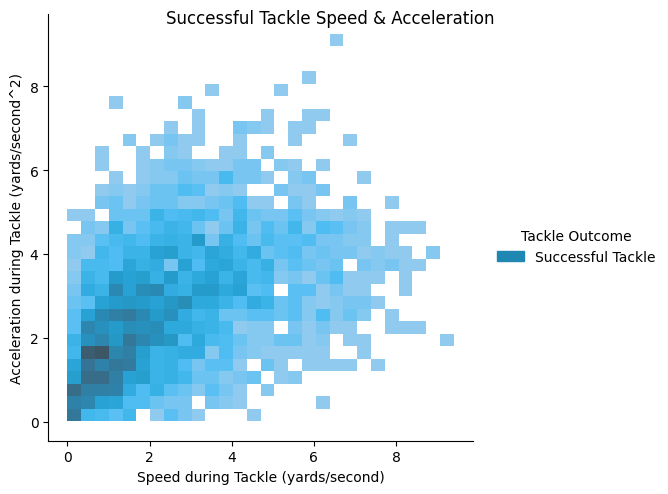

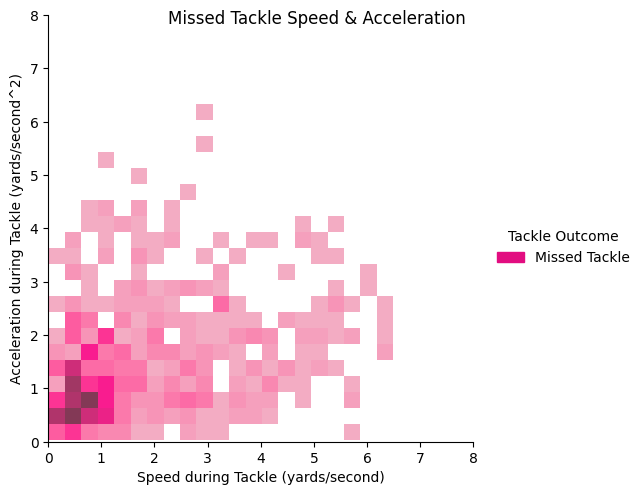

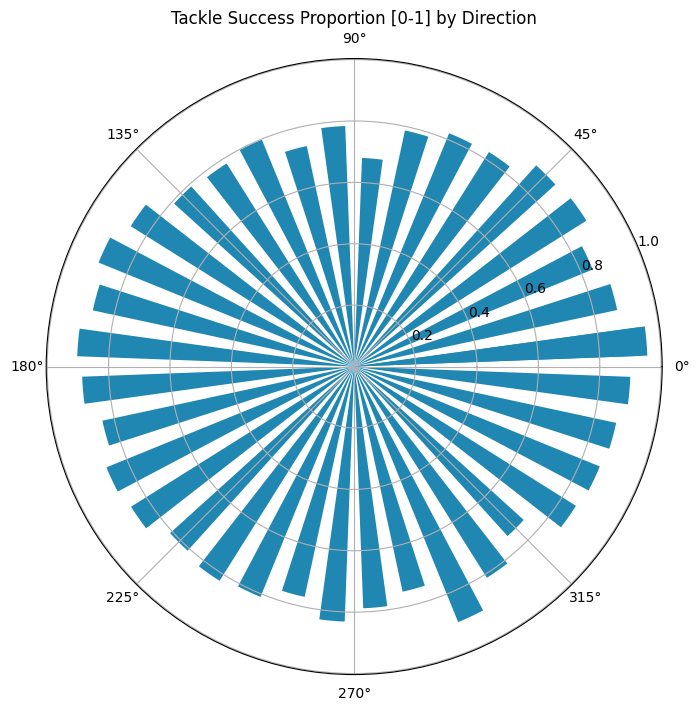

In [7]:
# In this part of the script we will now add a visualization for each 
# attribute in order to conclude our initial screening. Visual inspections
# of the variables can be quite useful in order to to catch patterns (or the 
# lack thereof) that can't be found by sticking to a single test statistic value.

import seaborn as sns
import matplotlib.pyplot as plt
# Auxiliary function to format values as (%) in the plots
from matplotlib.ticker import FuncFormatter
pcnt_formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
# Auxiliary function to splits camelCase in variable names by adding a space in between words
def splitCamelCase(text):
    return re.sub(r'([A-Z])', r' ' r'\1', text)
# Hide the "figure layout has been set to tight" warning because it provides no value
import warnings
warnings.filterwarnings('ignore', 'The figure layout has changed to tight')

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# A. Define auxiliary variables 
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
## Save tackle outcome as text for easier visualization in some plots
main_df["tackle_outcome_str"] = main_df["tackle_outcome"].apply(lambda x: "Missed Tackle" if x == 0 else "Successful Tackle" if x == 1 else np.nan)
## Get list of predictor variables ordered by significance
### Exclude non-analysis variables (ie. those with null statistical tests)
summary_df_ordered                        = summary_df.loc[summary_df["Anova P-Val"].notnull()].sort_values("Anova P-Val") 
### Flag binary variables so we know which visualization method to use for them
summary_df_ordered["is_binary_predictor"] = summary_df_ordered["Unique Values"] == 2 
summary_df_ordered.reset_index(drop = True, inplace = True) # Reset index 
## Auxiliary plot variables
outcome_palette = ["#e20d80", "#1f87b1"] # My personal preference for the plot colors
outcome_order   = ["Missed Tackle", "Successful Tackle"] # Outcome values (string)

#>>>>>>>>>>>>>>>>>>>>>>>>
# B. Make standard plots
#>>>>>>>>>>>>>>>>>>>>>>>>
# Create saving folder
os.makedirs(os.path.join(output_folder, "Attribute Plots"), exist_ok = True) # Exist ok avoids getting an error if this folder already exists
os.makedirs(os.path.join(output_folder, "Attribute Plots", "Alternative Categorical Display"), exist_ok = True) # We will save stacked charts on this folder

# Start plotting loop 
for i, row in summary_df_ordered.iterrows():
    # print(f"Plotting attribute {i}/{len(summary_df_ordered)}: {var}")
    # Fetch variable attributes for plot
    var            = row.Attribute
    print(f"Plotting attribute {i}/{len(summary_df_ordered)}: {var}")
    var_title_name = re.sub("_", " ", splitCamelCase(var)).title() # Name to use for the title of the plot
    var_title_name = re.sub("Event ", "Event: ", var_title_name) # Add a colon to event variables so its easier to understand what they mean
    var_pval       = summary_df.loc[summary_df.Attribute == var, "Anova P-Val"].round(3).iloc[0] # This attribute's p-value so we display it on the plot
    # Inspect what plot to make depending on the variable type
    if (main_df[var].dtype != "object") & (row.is_binary_predictor == False):
        #-----------------------
        # Numeric variable plot 
        #-----------------------
        # Numeric variables are the most straightforward. We simply create a boxplot with their values 
        # for each tackle outcome
        fig, ax = plt.subplots(dpi = 150)
        sns.boxplot(data = main_df.sort_values("tackle_outcome"), x = "tackle_outcome_str", y = var, hue = "tackle_outcome_str", 
                    order = outcome_order, width = 0.5, dodge = False, palette = outcome_palette) #, color = ["#e20d80", "#1f87b1"])
        plt.xlabel("Outcome")
        plt.ylabel(var_title_name)
        plt.title(f"Tackle Outcome by {var_title_name} [Pval = {var_pval}]")
        plt.legend().remove()
        fig.savefig(os.path.join(output_folder, "Attribute Plots", f"{i+1}. {var}.png"), bbox_inches = "tight")
    else:
        if row.is_binary_predictor == True: 
            #-----------------------
            # Binary predictor plot 
            #-----------------------
            # ---- (i) Success % plot ----
            cat_plot = sns.catplot(data = main_df, x = var, y = "tackle_outcome", errorbar=('ci', 68), kind = "bar", palette = ["#1f87b1", "#009B9C"]) 
            cat_plot.set_axis_labels(var_title_name, "% Successful Tackles")
            cat_plot.fig.suptitle(f"Tackle Outcome by {var_title_name} [Pval = {var_pval}]")
            plt.gca().yaxis.set_major_formatter(pcnt_formatter)
            cat_plot.savefig(os.path.join(output_folder, "Attribute Plots", f"{i+1}. {var}.png"), dpi = 200, bbox_inches = "tight")
            
            # ---- (ii) Stacked chart ----
            # This additional plot allows us to see the absolute outcome frequency and hence the imbalance between class occurrences
            success_counts                   = main_df.groupby(var).agg(successful_tackles = ("tackle_outcome", "sum"), total_tackles = ("tackle_outcome", "count")).reset_index()
            success_counts["missed_tackles"] = success_counts["total_tackles"] - success_counts["successful_tackles"]
        
            fig, ax = plt.subplots(dpi = 150)
            # Plot Value1
            sns.barplot(data=success_counts, x = var, y = 'successful_tackles', ax=ax, color="#1f87b1")
            sns.barplot(data=success_counts, x = var, y = 'missed_tackles', ax=ax, color="#e20d80")
            # Plot Value2 on top of Value1
            plt.xlabel(var_title_name)
            plt.ylabel("Total Tackles")
            plt.title(f"Tackle Outcome by {var_title_name} [Pval = {var_pval}]")
            # Add legend
            topbar = plt.Rectangle((0,0),1,1,fc="#e20d80", edgecolor = 'none')
            bottombar = plt.Rectangle((0,0),1,1,fc='#1f87b1',  edgecolor = 'none')
            l = plt.legend([bottombar, topbar], ['Missed', 'Successful'], loc='upper right', ncol = 2, prop={'size':8})
            l.draw_frame(False)
            fig.savefig(os.path.join(output_folder, "Attribute Plots", "Alternative Categorical Display", f"{i+1}. {var} (Stacked).png"), bbox_inches = "tight")
    
        else:
            # Comparing more than 3 or 4 categories is easier if the bars are horizontal, hence this special kind of plot for non-binary categoricals
            is_big_plot = row["Unique Values"] > 70
            #----------------------------
            # Categorical predictor plot 
            #----------------------------
            if row["Unique Values"] <= 200: # We can't handle a plot for more then 200 variables, it just looks too messy to interpret
                # ---- (i) Success % plot ----
                category_order = main_df.groupby(var).tackle_outcome.mean().sort_values().index
                cat_plot = sns.catplot(data = main_df, x = "tackle_outcome", y = var, errorbar=('ci', 68), kind = "bar", order = category_order, color = "#1f87b1") 
                cat_plot.set_axis_labels("% Successful Tackles", var_title_name)
                cat_plot.fig.suptitle(f"Tackle Outcome by {var_title_name} [Pval = {var_pval}]")
                plt.gcf().subplots_adjust(top=0.91)
                plt.gca().xaxis.set_major_formatter(pcnt_formatter)
                # Adjustments for BIG variables
                if is_big_plot:
                    cat_plot.tick_params(axis = "y", labelsize = "xx-small")
                    cat_plot.fig.set_size_inches(20, 15)
                cat_plot.savefig(os.path.join(output_folder, "Attribute Plots", f"{i+1}. {var}.png"), dpi = 200, bbox_inches = "tight")
                
                # ---- (ii) Stacked chart ----
                # This additional plot allows us to see the absolute outcome frequency and hence the imbalance between class occurrences
                ## Create auxiliary count table
                success_counts                   = main_df.groupby(var).agg(successful_tackles = ("tackle_outcome", "sum"), total_tackles = ("tackle_outcome", "count")).reset_index()
                success_counts["missed_tackles"] = success_counts["total_tackles"] - success_counts["successful_tackles"]
                category_order = success_counts.sort_values("total_tackles", ascending = False)[var] # Sort categories by # appearences

                ## Create plot
                fig, ax = plt.subplots(dpi = 150, figsize = (15,20))
                # Plot Value1
                sns.barplot(data=success_counts, x = 'successful_tackles', y = var, orient='h', ax=ax, color="#1f87b1", order = category_order)
                # Plot Value2 on top of Value1
                sns.barplot(data=success_counts, x = 'missed_tackles', y = var, orient='h', ax=ax, color="#e20d80", order = category_order)
                plt.yticks(size = "xx-small")
                plt.xlabel("Total Tackles")
                plt.ylabel(var_title_name)
                plt.title(f"Tackle Outcome by {var_title_name} [Pval = {var_pval}]")
                # Add legend
                topbar = plt.Rectangle((0,0),1,1,fc="#e20d80", edgecolor = 'none')
                bottombar = plt.Rectangle((0,0),1,1,fc='#1f87b1',  edgecolor = 'none')
                l = plt.legend([bottombar, topbar], ['Missed', 'Successful'], loc='lower right', ncol = 2, prop={'size':12})
                l.draw_frame(False)
                fig.savefig(os.path.join(output_folder, "Attribute Plots", "Alternative Categorical Display", f"{i+1}. {var} (Stacked).png"), bbox_inches = "tight")
    # Close all open plots in order to save memory
    plt.close('all')
        
    
#>>>>>>>>>>>>>>>>>>>>>>>>>
# Advanced visualizations
#>>>>>>>>>>>>>>>>>>>>>>>>>
os.makedirs(os.path.join(output_folder, "Advanced Visualizations"), exist_ok = True)

#-----------------
# Tackle Position 
#-----------------
# ---- (i) Position of successful tackles ----
position_fig = sns.displot(main_df.loc[main_df.tackle_outcome == 1].rename({"tackle_outcome_str": "Tackle Outcome"}, axis = 1), 
                           x="tackle_x_position", y="tackle_y_position", hue="Tackle Outcome", palette = [outcome_palette[1]])
position_fig.fig.suptitle("Position during Successful Tackles")
position_fig.set_axis_labels("X Positon at Tackle", "Y Positon at Tackle")
position_fig.savefig(os.path.join(output_folder, "Advanced Visualizations", "Successful Tackle Position.png"), 
                     bbox_inches = "tight", dpi = 200)

# ---- (ii) Position of missed tackles ----
position_fig = sns.displot(main_df.loc[main_df.tackle_outcome == 0].rename({"tackle_outcome_str": "Tackle Outcome"}, axis = 1),
                           bins = 21, x="tackle_x_position", y="tackle_y_position", hue="Tackle Outcome", palette = [outcome_palette[0]]) # bins parameter is to make the plot resemble the success plot side
position_fig.fig.suptitle("Position during Missed Tackles")
position_fig.set_axis_labels("X Positon at Tackle", "Y Positon at Tackle")
position_fig.savefig(os.path.join(output_folder, "Advanced Visualizations", "Missed Tackle Position.png"), 
                     bbox_inches = "tight", dpi = 200)

#--------------------------------
# Tackle Acceleration and Speed
#--------------------------------
# ---- (i) Momentum of successful tackles ----
movement_fig = sns.displot(main_df.loc[main_df.tackle_outcome == 1].rename({"tackle_outcome_str": "Tackle Outcome"}, axis = 1), 
                           x="tackle_speed", y="tackle_acceleration", hue="Tackle Outcome", palette = [outcome_palette[1]])
movement_fig.fig.suptitle("Successful Tackle Speed & Acceleration")
movement_fig.set_axis_labels("Speed during Tackle (yards/second)", "Acceleration during Tackle (yards/second^2)")
movement_fig.savefig(os.path.join(output_folder, "Advanced Visualizations", "Successful Tackle Speed and Acceleration.png"), 
                     bbox_inches = "tight", dpi = 200)

# ---- (ii) Momentum of missed tackles ----
movement_fig = sns.displot(main_df.loc[main_df.tackle_outcome == 0].rename({"tackle_outcome_str": "Tackle Outcome"}, axis = 1), 
                           bins = 21, x="tackle_speed", y="tackle_acceleration", hue="Tackle Outcome", palette = [outcome_palette[0]])
movement_fig.fig.suptitle("Missed Tackle Speed & Acceleration")
movement_fig.set_axis_labels("Speed during Tackle (yards/second)", "Acceleration during Tackle (yards/second^2)")
movement_fig.set(ylim = (0,8), xlim = (0,8)) # This and bins = 21 is for easier comparison between plots
movement_fig.savefig(os.path.join(output_folder, "Advanced Visualizations", "Missed Tackle Speed and Acceleration.png"), 
                     bbox_inches = "tight", dpi = 200)

#--------------------------------
# Success by tackle angle
#--------------------------------
# Create an auxiliary table with the grouped tackle angles 
## This is easier if we remove the null values
filtered_df                     = main_df.loc[main_df.tackle_angle.notnull()] 
filtered_df["tackle_angle_bin"] = round(filtered_df.tackle_angle/10)*10 + 5
# Summarize success by angle
angle_summary_df = filtered_df.groupby("tackle_angle_bin").agg(success_rate = ("tackle_outcome", "mean"), observations = ("tackle_outcome", "count")).reset_index()
## Convert  to radians (required for plot)
angle_summary_df["tackle_angle_radians"] = np.deg2rad(angle_summary_df['tackle_angle_bin'])

# Create polar axis plot
angle_fig = plt.figure(figsize=(8,8))
ax = angle_fig.add_subplot(111, polar=True)
ax.bar(angle_summary_df["tackle_angle_radians"], angle_summary_df['success_rate'], width=0.1, color = "#1f87b1")
plt.title("Tackle Success Proportion [0-1] by Direction")
angle_fig.savefig(os.path.join(output_folder, "Advanced Visualizations", "Outcome by Tackle Angle.png"), bbox_inches = "tight")


## IV. Arrange Data for Modeling

In [8]:
import pandas as pd
import os, re
import datetime
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Location that contains the preprocessed overall table
input_folder   = "./reports"

main_df         = pd.read_parquet(os.path.join(input_folder, "main_df.parquet"))
stat_summary_df = pd.read_excel(os.path.join(input_folder, "Attribute Statistical Summary.xlsx"))

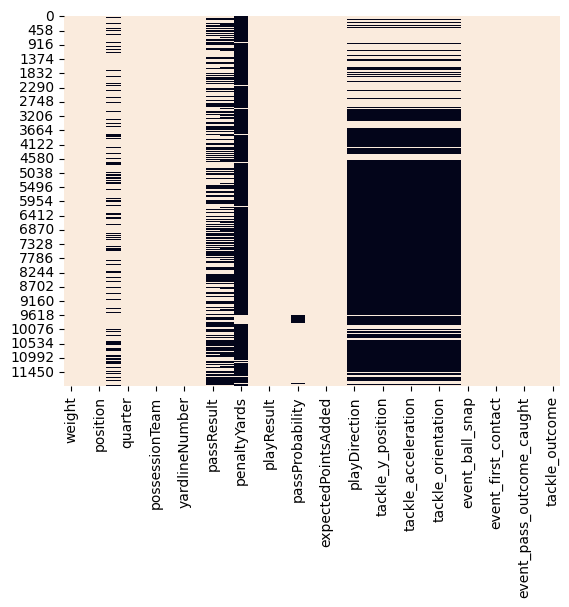

In [10]:
# A quick custom function to visualize missing values
def vis_miss(df):
    import seaborn as sns
    sns.heatmap(df.notnull(), cbar=False)

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Subset dataset to significant variables
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
## Define output column for easier access
outcome_col      = "tackle_outcome"
## Keep only variables that passed the Anova test for the model 
## (for the other ones aren't statistically significant)
significant_vars = stat_summary_df.loc[stat_summary_df["Anova P-Val"] < 0.05, "Attribute"].tolist()
main_sub         = main_df[significant_vars + [outcome_col]]
# Remove variables with low or null face value (or possible leakage)
## Touchdown events "cheat" the model by telling us the tackle wasn't successful. I don't want player names 
## in the model because we prediction here should rely on more general attributes other than what your name is. 
## Jersey Number is significant but totally devoid of face-values (and it probably cheats the model into memorizing players instead of
## strategy considerations.. individual player performances are to volatile and changing with time to rely on them)
## Frame Id might (or might not) be a cheating variable and I'm unsure about it... (The reasoning for it is that, because it stops the moment 
## a successful tackle happens, we might be adding a variable that already knows the outcome of the play to the model. But I'm not sure about it)
## YardlineSide is also too related to defense team and the yardlinehalf variable, and "Club" is identical to 
## defenseTeam (because we're looking at tackles and the defense team is the club that makes them)
vars_to_remove = ["frameId", "jerseyNumber", "event_touchdown", "displayName", "ballCarrierDisplayName", 
                  "yardlineSide", "club"] 
main_sub       = main_sub[[col for col in main_sub.columns if col not in vars_to_remove]]

#>>>>>>>>>>>>>>>>>>>>>>>>
# Missing value analysis
#>>>>>>>>>>>>>>>>>>>>>>>>
# Most models can't handle missing values within the data 
# hence we need to check the rows and columns and take out 
# some of them

# Plot missing values
vis_miss(main_sub)
# Quantify missing values per column
col_missing_values = main_sub.isna().mean()
col_missing_values = col_missing_values.reset_index().set_axis(["Attribute", "Pcnt_Missing"], axis = 1)
## Unfortunately, only a third of our observations have tackle force data (tackle 'x' position, tackle speed, etc)
## so we need to either exclude these attributes altogether, or do away with 70% of our observations..
## The real answer is that we need to try both models (for all we know they might be the best predictors), but for
## this script I'll be keeping them, for I consider them to be the most interesting predictors. The user will be free to try 
## an alternative model at his own pace.

# Removal of columns based on missing values
allowed_na_pcnt      = 0.8 # This allows us to keep the tackle attributes, but we can lower it to do away with them 
attributes_to_keep   = col_missing_values.loc[col_missing_values.Pcnt_Missing <= allowed_na_pcnt, "Attribute"]
main_sub             = main_sub[attributes_to_keep]

# Keep only complete cases
# main_lm = main_sub.loc[main_sub.notnull().all(axis = 1)]
## Note: This is the natural step that would happen here. However, the missing values in 
## "age", "passResult", and "passLength" do not match those of the tackle information and
## thus leave us with 1k rows (only 9% of the dataset!) this we will manually remove them
## and hence preserve 2 extra thirds of our dataset 
main_sub.drop(["age", "passResult", "passLength"], axis = 1, inplace = True)
# Keep complete cases only
main_sub = main_sub.loc[main_sub.notnull().all(axis = 1)]


#>>>>>>>>>>>>>>>>>>>>>>>>
# Create dummy variables
#>>>>>>>>>>>>>>>>>>>>>>>>
# Note: The sheer amount of colleges [171] makes it impossible for a logistic model to be trained 
# on this dataset - given that we need to one-hot encode categoricals into dummy 0-1 columns. 
# Dropping this variable is however not required if a different classification model is intended to be 
# trained
main_sub.drop(["collegeName"], axis = 1, inplace = True)

# Get the categorical columns
col_types         = main_sub.dtypes.reset_index().set_axis(["Attribute", "Type"], axis = 1)
category_columns  = col_types.loc[col_types.Type == "object", "Attribute"]
# Encode categorical columns
classification_df = pd.get_dummies(main_sub, columns = category_columns, drop_first=True, dtype = int)

# # Some columns were perfect duplicates of each other (ex. club and defensiveTeam), so we had to remove them
# # originally so by transposing the dataset, dropping duplicates, and then reverting it to its original origntation
# # this no longer seems to be a problem and hence the instruction has been commented out.
# classification_df = classification_df.transpose().drop_duplicates().transpose()

## V. Classification Model & Presentation Results

Removing non-significant predictor. 88 attributes left in model..
Removing non-significant predictor. 78 attributes left in model..
Removing non-significant predictor. 68 attributes left in model..
Removing non-significant predictor. 58 attributes left in model..
Removing non-significant predictor. 48 attributes left in model..
Removing non-significant predictor. 38 attributes left in model..
Removing non-significant predictor. 28 attributes left in model..
Removing non-significant predictor. 18 attributes left in model..
Backward elimination is complete. Model is ready!


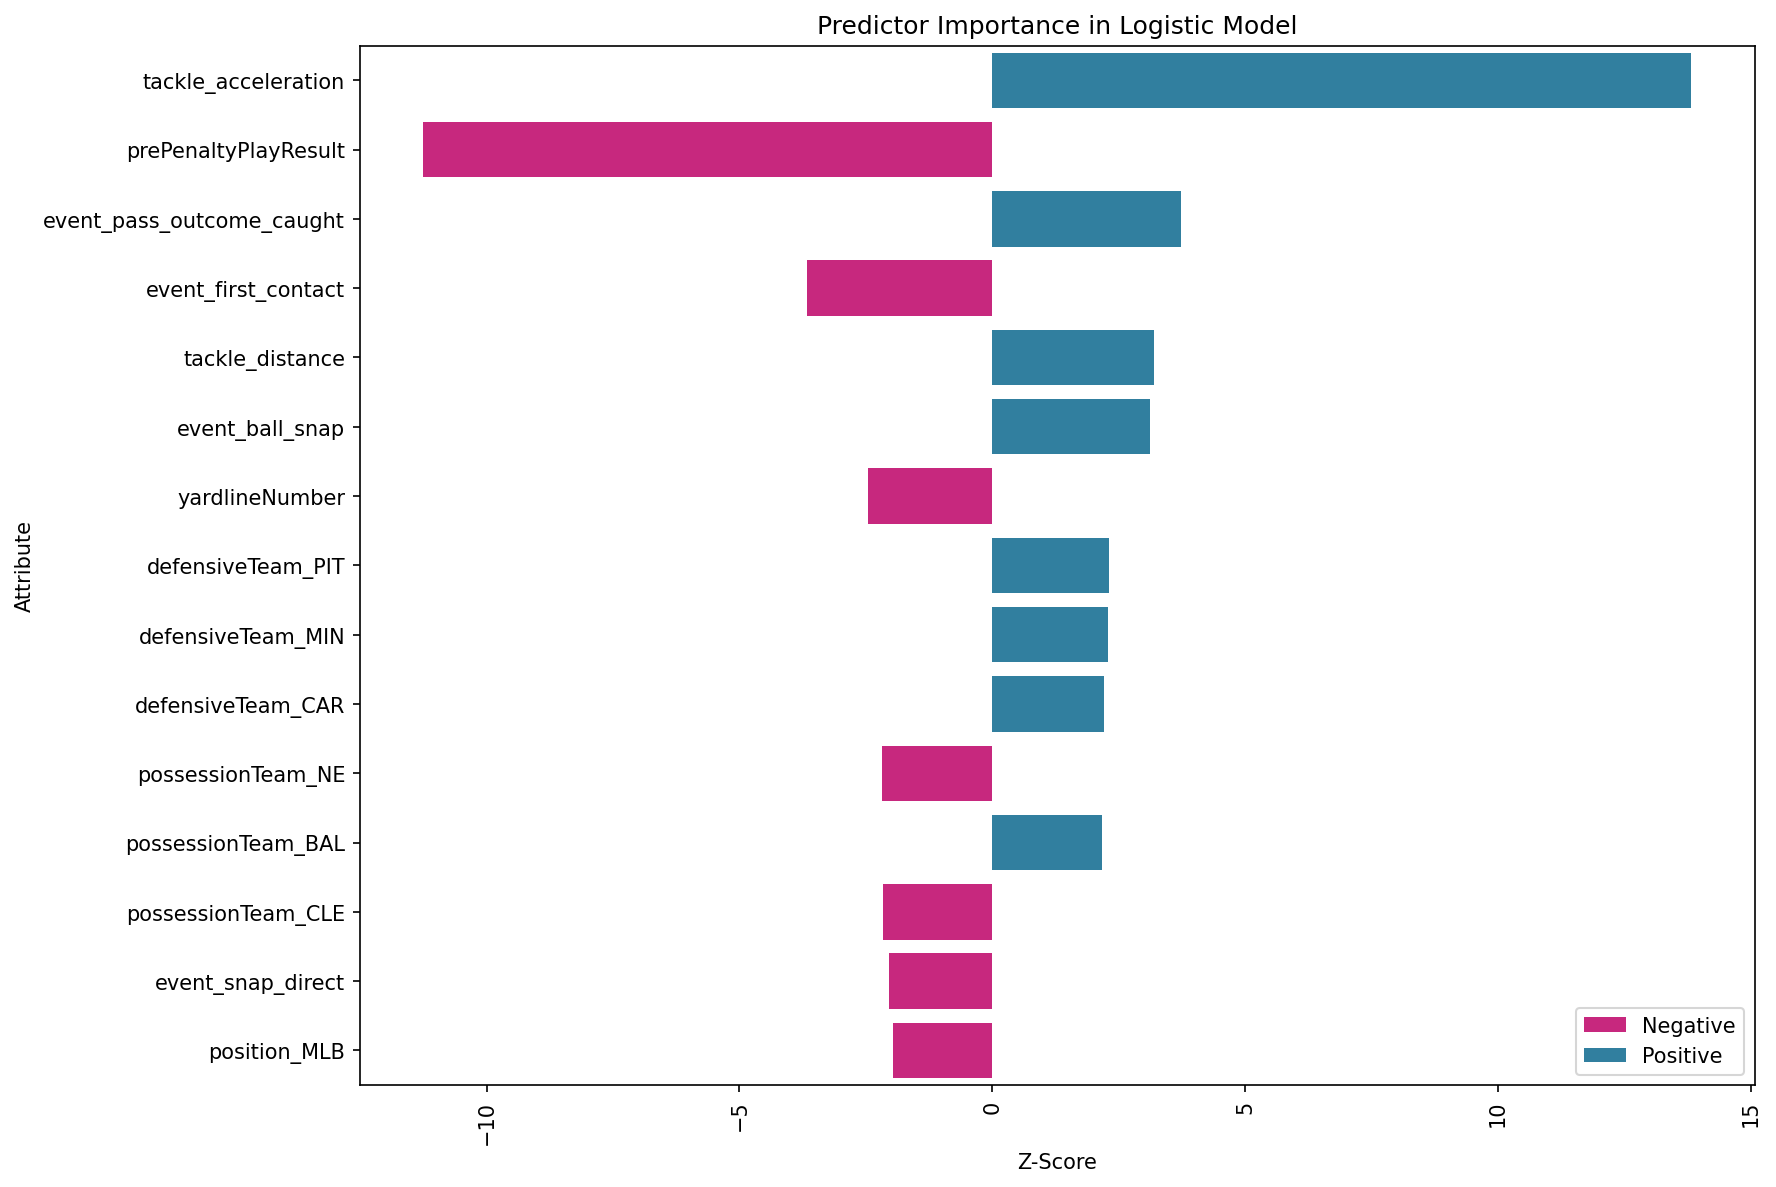

In [11]:
import statsmodels.api as sm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
# Get optimal cutoff for a probability-based classification model
def getOptimalCutoff(true_obs, predicted_probs):
    """
    Computes Youden's J statistic, which is the most popular method to determine the optimal cut-off point for a binary classifier 
    """
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(true_obs, predicted_probs)
    ## Get J statistic
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    return j_ordered[-1][1]

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# A. Create train and test sets 
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Get train and test sets
train_set, test_set = train_test_split(classification_df, test_size=0.2, random_state=15648)
## Get train set
x_train = train_set.drop(outcome_col, axis = 1)
y_train = train_set[outcome_col]
## Get test set
x_test  = test_set.drop(outcome_col, axis = 1)
y_test  = test_set[outcome_col]

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# B. Train logistic model
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Do backward stepwise regression on our dataset till all prector attributes are significant
## Create auxiliary variables
x_train_sub        = x_train.copy() # Auxiliary dataframe that we'll be dropping non-significant columns from
max_p_value        = 1 # Initialize max p-value in model
significance_level = 0.05
iteration_counter  = 0
## Berform backwards stepwise regression
while max_p_value > significance_level:
    model          = sm.Logit(y_train, sm.add_constant(x_train_sub)).fit(disp=0)
    model_p_values = model.pvalues.reset_index().set_axis(["attribute", "pval"], axis = 1)
    model_p_values = model_p_values.loc[model_p_values.attribute != "const"].set_index("attribute")["pval"] # We want to convert it back to a series with attributes as its indexes
    max_p_value = max(model_p_values)
    if max_p_value >= significance_level:
        ## Iteratively print an update every 10 iterations
        iteration_counter += 1
        if ((iteration_counter+1) % 10) == 0:
            print(f"Removing non-significant predictor. {x_train_sub.shape[1]-1} attributes left in model..")
        ## Remove predictor
        predictor_to_remove = model_p_values.idxmax()
        x_train_sub.drop(predictor_to_remove, axis = 1, inplace = True)
    else:
        print("Backward elimination is complete. Model is ready!")

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# C. Inspect prediction formula and predictor importance
#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# -- Inspect attributes in final model --
# This is the model being used for prediction. Inspecting it should bring in several interesting insights
# using these coefficients in the logistic equation gets us a formula for predicting tackles and misses
model.summary()  
# Export model summary
with open(os.path.join(input_folder, 'Logistic Model Summary.txt'), 'w') as fh:
    fh.write(str(model.summary()))
    
# -- Plot model coefficients --
# Extract coefficients, standard errors, and z-scores
coeff    = model.params
std_err  = model.bse
z_scores = model.tvalues # Same as coefficients divided by standard error

# Get predictor importances
## z-scores are a good proxy for predictor importance, given that they estimate how many standard 
## deviations an attribute is away from the mean log ods of our output variable
predictor_importance = z_scores.reset_index().set_axis(["Attribute", "Z-Score"], axis = 1) 
## Remove the intercept constant
predictor_importance = predictor_importance.loc[predictor_importance.Attribute != "const"]
## Order by absolute value
predictor_importance["abs_z_score"] = predictor_importance["Z-Score"].abs()
predictor_importance.sort_values("abs_z_score", ascending = False, inplace = True)
## Add prediction direction
predictor_importance["Direction"] = predictor_importance["Z-Score"].apply(lambda x: "Positive" if x > 0 else "Negative")

# Make plot
fig, ax = plt.subplots(dpi = 150, figsize = (12,9))
sns.barplot(data = predictor_importance, y = "Attribute", x = "Z-Score", hue = "Direction", 
            orient = "h", palette = ["#e20d80", "#1f87b1"], hue_order = ["Negative", "Positive"], 
            order = predictor_importance.Attribute, dodge = False)
plt.xticks(rotation = 90)
plt.title("Predictor Importance in Logistic Model")
plt.legend(loc='lower right')
fig.savefig(os.path.join(input_folder, "Predictor Importance.png"), bbox_inches = "tight")

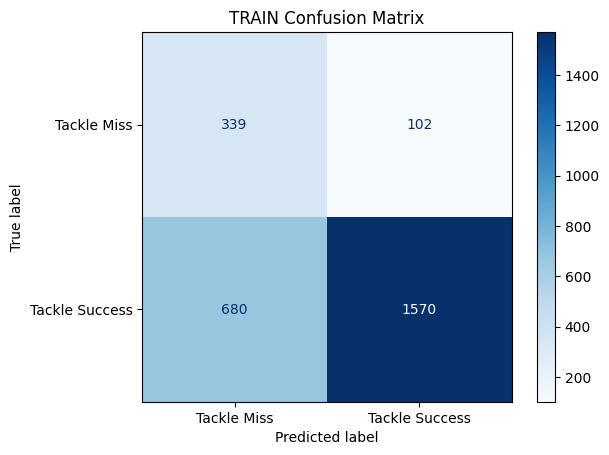

In [12]:
#>>>>>>>>>>>>>>>>>>>>
# D. Evaluate model
#>>>>>>>>>>>>>>>>>>>>
# Auxiliary variables
output_labels = ["Tackle Miss", "Tackle Success"]
# A quick auxiliary function to convert 0s to 'Misses' and 1s to 'Success'
def labelOutput(list_):
    return ["Tackle Miss" if value == 0 else "Tackle Success" if value == 1 else value for value in list_]

#-------------------------
# i. Train set evaluation
#-------------------------
# -- Evaluate train predictions --
predicted_probs_train = model.predict()
## Compute optimal cutoff threshold
cutoff_threshold  = getOptimalCutoff(y_train, predicted_probs_train)
## Get actual prediction
prediction_train  = [0 if prob < cutoff_threshold else 1 for prob in predicted_probs_train]

# Plot confusion matrix
## Numeric matrix
cmat = confusion_matrix(labelOutput(y_train), labelOutput(prediction_train), labels = output_labels)
## Matrix plot
fig = ConfusionMatrixDisplay(cmat, display_labels = output_labels).plot(cmap=plt.cm.Blues)
plt.title("TRAIN Confusion Matrix")
plt.savefig(os.path.join(input_folder, "Train Confusion Matrix.png"), bbox_inches='tight', dpi = 100)

In [13]:
# -- Performance metrics --
# compute accuracy
accuracy = metrics.accuracy_score(y_train, prediction_train)
print('TRAIN Accuracy: {:.2f}'.format(accuracy))
# compute sensitivity
sensitivity = metrics.recall_score(y_train, prediction_train)
print('TRAIN Sensitivity: {:.2f}'.format(sensitivity))
# compute specificity
tn, fp, fn, tp = metrics.confusion_matrix(y_train, prediction_train).ravel()
specificity = tn / (tn+fp)
print('TRAIN Specificity: {:.2f}'.format(specificity))
# compute F1-score
f1_score = metrics.f1_score(y_train, prediction_train)
print('TRAIN F1 Score: {:.2f}'.format(f1_score))

TRAIN Accuracy: 0.71
TRAIN Sensitivity: 0.70
TRAIN Specificity: 0.77
TRAIN F1 Score: 0.80


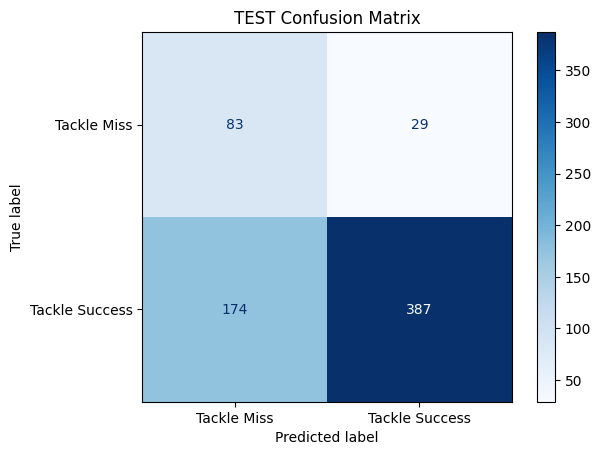

In [14]:
#-------------------------
# ii. Test set evaluation
#-------------------------
# -- Evaluate test set predictions --
## We removed several columns on x_train and hence need our test set 
## to only have what's needed too
x_test_sub            = x_test[[col for col in x_test.columns if col in x_train_sub.columns]] 
prediction_probs_test = model.predict(sm.add_constant(x_test_sub))
## Get actual prediction
prediction_test       = [0 if prob < cutoff_threshold else 1 for prob in prediction_probs_test]

# Plot confusion matrix
## Numeric matrix
cmat_test = confusion_matrix(labelOutput(y_test), labelOutput(prediction_test), labels = output_labels)
## Matrix plot
fig_test  = ConfusionMatrixDisplay(cmat_test, display_labels = output_labels).plot(cmap=plt.cm.Blues)
plt.title("TEST Confusion Matrix")
plt.savefig(os.path.join(input_folder, "Test Confusion Matrix.png"), bbox_inches='tight', dpi = 100)

In [15]:
# -- Performance metrics --
# compute accuracy
accuracy = metrics.accuracy_score(y_test, prediction_test)
print('TEST Accuracy: {:.2f}'.format(accuracy))
# compute sensitivity
sensitivity = metrics.recall_score(y_test, prediction_test)
print('TEST Sensitivity: {:.2f}'.format(sensitivity))
# compute specificity
tn, fp, fn, tp = metrics.confusion_matrix(y_test, prediction_test).ravel()
specificity = tn / (tn+fp)
print('TEST Specificity: {:.2f}'.format(specificity))
# compute F1-score
f1_score = metrics.f1_score(y_test, prediction_test)
print('TEST F1 Score: {:.2f}'.format(f1_score)) 

TEST Accuracy: 0.70
TEST Sensitivity: 0.69
TEST Specificity: 0.74
TEST F1 Score: 0.79
